
# Federated Learning

## Frecency Sampling

To be able to quickly prototype the Federated Learning algorithm, a dataset is required.
This notebook is based on a fake frecency dataset that was designed to be very interpretable and at the same time close to the actual data.
The assumption for the data generation is that the current frecency algorithm is perfect. By sampling based on this axiom, we can check if the algorithm really finds the global optimum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sampling the model input

These are weights that describe how common certain features are. For `recency` we assume a uniform distribution over time, for `type` numbers were chosen that intuitively seem to be reasonable.

In [2]:
type_weights = {
    "visited": 0.6,
    "typed": 0.2,
    "bookmarked": 0.2,
    #"other_type": 0.1
}

**Note:** Actually there's also a feature `other_type` which has a weight of `0` in the original frecency algorithm, i.e. it's not really used. If we use this feature for this training process, it adds noise to the model because the model has not enough data to learn that this feature does not really add value. 

In [3]:
recency_weights = {
    "4-days": 0.03,
    "14-days": 0.05,
    "31-days": 0.1,
    "90-days": 0.32,
    "other_recency": 0.5
}

In [4]:
recency_weights = {
    "4-days": 0.15,
    "14-days": 0.15,
    "31-days": 0.15,
    "90-days": 0.2,
    "other_recency": 0.35
}

For the simulation, it seems to be a fair assumption that `type` and `recency` are independent of each other.
This means we can just multiply the probabilities.

This is probably not completely true, since users likely visit bookmarks more often, but it makes things easier here and the probabilities are hard to estimate well anyways.

In [5]:
def combine_dicts_multiplicatively(dict1, dict2):
    """
    Returns a new dict where the keys consist of all pairs of keys from the input
    dictionaries and the values correspond to the respective multiplied values.
    """
    weights = {}

    for key1, weight1 in dict1.items():
        for key2, weight2 in dict2.items():
            key = (key1, key2)
            weight = weight1 * weight2
            weights[key] = weight
            
    return weights

In [6]:
weights = combine_dicts_multiplicatively(type_weights, recency_weights)

A one-hot representation makes it easier to implement the rest of the formulas. numpy allows us to generate this easily using a permutation of the identity matrix.

In [7]:
def one_hot(num_choices, vector):
    return np.eye(num_choices)[vector]

The input vector to the model is 20-dimensional: One field for every combination of `type` and `recency`.
In the frecency algorithm, we consider the last ten visits to the URL.
Thus, the sum of all elements of the vector is a natural number between 1 and 10.

(Since `other-type` is commented out, it's only 15-dimensional for now.)

In [8]:
def sample_weighted(num_samples, weight_dict):
    """Randomly sample from a dict using the values as probabilities"""
    num_choices = len(weight_dict)
    choice_weights = weight_dict.values()
    samples = np.random.choice(num_choices, num_samples, p=choice_weights)
    return one_hot(num_choices, samples)

In [9]:
def sample_url_features(num_samples):
    return sample_weighted(num_samples, weights)

### Sampling the target labels

These are the weights found in the current frecency algorithm. Based on the one-hot encoding, this is just a linear function.

In [10]:
type_points = {
    "visited": 1.2,
    "typed": 2,
    "bookmarked": 1.4,
    #"other_type": 0
}

In [11]:
recency_points = {
    "4-days": 100,
    "14-days": 70,
    "31-days": 50,
    "90-days": 30,
    "other_recency": 10
}

In [12]:
frecency_points_dict = combine_dicts_multiplicatively(type_points, recency_points)

To make sure that the order of keys is the same everywhere:

In [13]:
key_order = weights.keys()
frecency_points = np.array([frecency_points_dict[key] for key in key_order])

This gives us the frecency points from the original algorithm:

In [14]:
zip(key_order, frecency_points)

[(('visited', '4-days'), 120.0),
 (('visited', '90-days'), 36.0),
 (('bookmarked', '14-days'), 98.0),
 (('bookmarked', 'other_recency'), 14.0),
 (('typed', 'other_recency'), 20.0),
 (('typed', '31-days'), 100.0),
 (('typed', '14-days'), 140.0),
 (('bookmarked', '31-days'), 70.0),
 (('typed', '4-days'), 200.0),
 (('bookmarked', '90-days'), 42.0),
 (('visited', '31-days'), 60.0),
 (('bookmarked', '4-days'), 140.0),
 (('visited', 'other_recency'), 12.0),
 (('typed', '90-days'), 60.0),
 (('visited', '14-days'), 84.0)]

After all these preparations, an arbitrary number of frecency scores can be computed using a single matrix multiplication.

In [15]:
def frecency(url_features):
    return url_features.dot(frecency_points)

Finally, we are sampling from the above distributions and then call the frecency function.

In [16]:
def sample(num_samples):
    X = sample_url_features(num_samples)
    y = frecency(X)
    return X, y

## Linear Regression

This section is mostly to check that's it possible to fit a linear model perfectly to the data.

In [17]:
from sklearn.linear_model import LinearRegression

To fit a model, we sample a lot of these scores and also add noise on top to make the problem more similar to the real application.

In [18]:
n = int(1e6)
noise = np.random.normal(0, 2, size=(n))
X, y = sample(n)
y += noise

In [19]:
model = LinearRegression(fit_intercept=False)

In [20]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

The resulting coefficients are extremely close to the actual frecency weights. How close they are depends on how much noise we add to the data matrix.

In [21]:
zip(model.coef_, frecency_points)

[(119.99802481019123, 120.0),
 (36.010567985223311, 36.0),
 (97.995720388746463, 98.0),
 (14.013362856717283, 14.0),
 (19.981025356822595, 20.0),
 (100.00182471338123, 100.0),
 (139.99585495891921, 140.0),
 (70.001437429367925, 70.0),
 (199.99038800729065, 200.0),
 (42.014639513858377, 42.0),
 (60.007080963939458, 60.0),
 (139.98948990746254, 140.0),
 (12.003933468345924, 12.0),
 (59.996823581902923, 60.0),
 (83.994141954805158, 84.0)]

In [22]:
model.coef_ - frecency_points

array([-0.00197519,  0.01056799, -0.00427961,  0.01336286, -0.01897464,
        0.00182471, -0.00414504,  0.00143743, -0.00961199,  0.01463951,
        0.00708096, -0.01051009,  0.00393347, -0.00317642, -0.00585805])

## Ranking

Now, we make the problem slightly more difficult: Instead of just learning the frecency function from data, we try to learn it from user interactions. The training data now consists of a variable number of history suggestions and their respective features. The label corresponds to the suggestion that the user clicked on. We still assume that the user clicks on the item with the highest frecency score.

In [23]:
n = 400

How many suggestions match the search query is sampled from a normal distribution centered around `10`.

In [24]:
num_options = np.random.normal(loc=10, scale=4, size=(n))
num_options = np.maximum(num_options, 1)
num_options = np.int32(num_options)

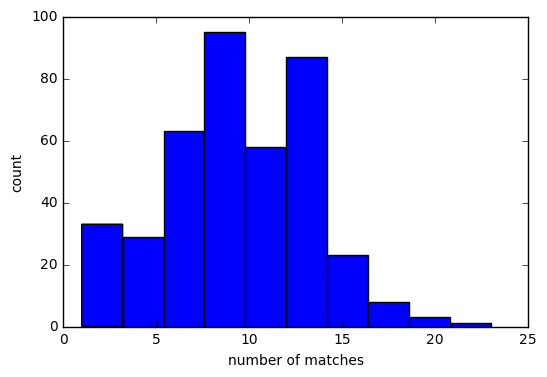

In [25]:
plt.hist(num_options)
plt.xlabel("number of matches")
plt.ylabel("count")

In [90]:
def sample_suggestions_normal(n):
    num_options = np.random.normal(loc=10, scale=4, size=(n))
    num_options = np.maximum(num_options, 1)
    num_options = np.int32(num_options)
    
    X, y = zip(*[sample(n) for n in num_options])
    #y = [yi + np.random.normal(0, 5, size=(n)) for yi, n in zip(y, num_options)]
    return X, y

In [91]:
def sample_suggestions_spark(n):
    num_options = np.random.normal(loc=10, scale=4, size=(n))
    num_options = np.maximum(num_options, 1)
    num_options = np.int32(num_options)
    
    rdd = sc.parallelize(num_options)
    data = rdd.map(lambda n: sample(n)).collect()
    X, y = zip(*data)
    
    return X, y

In [92]:
def sample_suggestions(n):
    if n > 1000:
        return sample_suggestions_spark(n)
    else:
        return sample_suggestions_normal(n)

## Hinge Loss

After preparing the training data, we can try to use the adapted SVM loss (also called [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)) for ranking.

In [31]:
n = int(1e3)
X, y = sample_suggestions(n)

Gradient descent generally works better when the data is centered around the origin:

In [32]:
def flatten(X):
    X_flat = []

    for x in X:
        X_flat += list(x)

    return np.array(X_flat)

In [33]:
def normalize(X):
    X_flat = flatten(X)
    mu = X_flat.mean(axis=0)
    return [x - mu for x in X]

In [34]:
X = normalize(X)

The optimizer we use is fairly simple: It scales the gradient with a learning rate before adding it to the model.
This abstraction as a class is still nice because we can later replace it with more sophisticated optimizers.

In [35]:
class GradientDescent:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def __call__(self, gradient):
        return self.learning_rate * gradient

To supervise training, we keep logging the loss:

In [36]:
def svm_loss(preds, ys, delta=0):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

During training, we want to supervise the learning process and save the best models.

In [37]:
class ModelCheckpoint:
    def __init__(self, metric_fn, num_sampled=10000):
        self.best_model = None
        self.best_metric = -np.inf
        self.metric_fn = metric_fn
        self.num_sampled = num_sampled
    
    def __call__(self, model):
        X_val, y_val = sample_suggestions(self.num_sampled)
        metric = self.metric_fn(y_val, model.predict(X_val))
        
        if metric > self.best_metric:
            self.best_metric = metric
            self.best_model = model
            print("[ModelCheckpoint] New best model with %.5f validation accuracy" % metric)
        else:
            print("validation: %.3f accuracy" % metric)

accuracy needs to be measured carefully here: In our simulation, we assume that the current frecency is the perfect ranking function. But because items sometimes get the same frecency scores, there can be more than one correct answer:

In [38]:
def rank_accuracy(y, preds):
    correct = 0.
    
    for yi, pi in zip(y, preds):
        if yi[pi.argmax()] == yi.max():
            correct += 1
            
    return correct / len(y)

The `SVMRanking` class is the main mechanism for fitting models.

In [39]:
class SVMRanking:
    def __init__(self, delta):
        self.delta = delta
        
    def fit(self, data_generator, optimizer, num_iterations=10, callbacks=[]):
        X, y = data_generator(1)
        num_features = X[0].shape[1]
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100
        
        for j in range(num_iterations):
            X, y = data_generator(400)
            
            preds = self.predict(X)
            gradient = np.zeros(num_features)

            for xi, pi, yi in zip(X, preds, y):
                correct = yi.argmax()
                score_correct = pi[correct]

                for i, predicted_score in enumerate(pi):
                    gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            gradient /= len(X)
            
            loss = np.mean([svm_loss(pi, yi) for pi, yi in zip(self.predict(X), y)])
            accuracy = rank_accuracy(y, model.predict(X))
            
            print("[%d/%d] training: %.5f loss, %.3f accuracy" % (j + 1, num_iterations, loss, accuracy))
            
            for callback in callbacks:
                callback(self)
            
            self.W += optimizer(gradient)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [40]:
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy)])

[1/48] training: 10.22065 loss, 0.800 accuracy
[ModelCheckpoint] New best model with 0.79410 validation accuracy
[2/48] training: 9.47784 loss, 0.870 accuracy
[ModelCheckpoint] New best model with 0.87370 validation accuracy
[3/48] training: 4.99000 loss, 0.902 accuracy
[ModelCheckpoint] New best model with 0.92360 validation accuracy
[4/48] training: 0.84757 loss, 0.958 accuracy
[ModelCheckpoint] New best model with 0.96790 validation accuracy
[5/48] training: 0.02241 loss, 0.985 accuracy
[ModelCheckpoint] New best model with 0.96990 validation accuracy
[6/48] training: 0.14086 loss, 0.948 accuracy
validation: 0.969 accuracy
[7/48] training: 0.02721 loss, 0.965 accuracy
[ModelCheckpoint] New best model with 0.97250 validation accuracy
[8/48] training: 0.02937 loss, 0.955 accuracy
validation: 0.967 accuracy
[9/48] training: 0.05865 loss, 0.955 accuracy
validation: 0.970 accuracy
[10/48] training: 0.03926 loss, 0.970 accuracy
[ModelCheckpoint] New best model with 0.97330 validation accu

After fitting, we can compare the learned weights with the true frecency scores. Note that the values themselves are very different now but that the ordering is nearly the same as in the real algorithm. This shows that we are ranking very similarly to the real algorithm but that the optimization process did not fully reach the global optimum.

In [41]:
ais = np.argsort(frecency_points)
zip(frecency_points[ais], model.W[ais])

[(12.0, -54.997429858574307),
 (14.0, -45.378725346158163),
 (20.0, -7.3333860382692366),
 (36.0, -7.616906081028044),
 (42.0, -7.8766284443188539),
 (60.0, 1.4293049359794734),
 (60.0, 1.4264637438576289),
 (70.0, 2.5920615423223636),
 (84.0, 2.5920615412049273),
 (98.0, 55.199984440426711),
 (100.0, 55.199985621167066),
 (120.0, 86.949523769832126),
 (140.0, 121.10334264784883),
 (140.0, 121.10334264784883),
 (200.0, 173.76717522094577)]

Still, the model is correct most of the time:

In [42]:
X, y = sample_suggestions(10000)
rank_accuracy(y, model.predict(X))

0.9846

### Side note: Evaluation during training in production

If we only use 400 data points for validating the current model, then this is not enough to properly assess the model quality.
The accuracies jump too much.
However, this evaluation could still be used to test that the model is not completely off.

(array([   4.,   11.,   47.,   65.,  109.,  286.,  163.,  247.,   51.,   16.]),
 array([ 0.965 ,  0.9685,  0.972 ,  0.9755,  0.979 ,  0.9825,  0.986 ,
         0.9895,  0.993 ,  0.9965,  1.    ]),
 <a list of 10 Patch objects>)

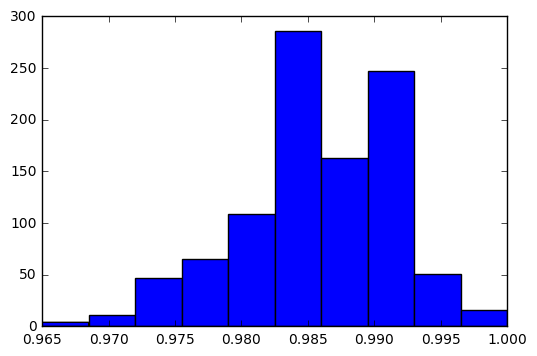

In [66]:
X, y = sample_suggestions(1000 * 400)
accuracies = []

for i in range(0, len(X) - 400, 400):
    Xi, yi = X[i:i+400], y[i:i+400]
    acc = rank_accuracy(yi, model.predict(Xi))
    accuracies.append(acc)
    
plt.hist(sorted(accuracies))

## Frequency

We still need to take into account that users visit links more than once.
How often a user visits a link is sampled from an exponential distribution in this simulation:

(array([ 493.,  229.,  143.,   68.,   33.,   15.,    7.,    8.,    2.,    2.]),
 array([  0. ,   4.4,   8.8,  13.2,  17.6,  22. ,  26.4,  30.8,  35.2,
         39.6,  44. ]),
 <a list of 10 Patch objects>)

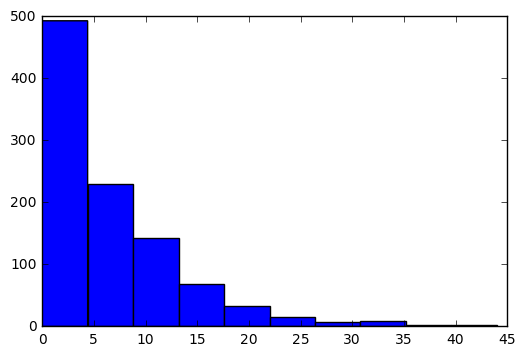

In [67]:
frequencies = np.int32(np.random.exponential(7, size=(1000)))
plt.hist(frequencies)

In [68]:
def sample_url_features(num_samples):
    frequencies = np.int32(np.random.exponential(7, size=num_samples)) + 1
    frequencies = np.int32(np.ones(num_samples))
    X = []
    
    for frequency in frequencies:
        num_sampled = min(10, frequency)
        features = sample_weighted(num_sampled, weights).sum(axis=0)
        X.append(frequency / num_sampled * features)
        
    return np.array(X)

In [69]:
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy, 10000)])

[1/48] training: 6.68685 loss, 0.838 accuracy
[ModelCheckpoint] New best model with 0.84440 validation accuracy
[2/48] training: 0.99414 loss, 0.950 accuracy
[ModelCheckpoint] New best model with 0.96520 validation accuracy
[3/48] training: 0.69720 loss, 0.973 accuracy
[ModelCheckpoint] New best model with 0.97010 validation accuracy
[4/48] training: 0.31055 loss, 0.973 accuracy
validation: 0.969 accuracy
[5/48] training: 0.13849 loss, 0.968 accuracy
validation: 0.968 accuracy
[6/48] training: 0.11023 loss, 0.973 accuracy
validation: 0.970 accuracy
[7/48] training: 0.10748 loss, 0.975 accuracy
[ModelCheckpoint] New best model with 0.97050 validation accuracy
[8/48] training: 0.03272 loss, 0.975 accuracy
[ModelCheckpoint] New best model with 0.97330 validation accuracy
[9/48] training: 0.15880 loss, 0.973 accuracy
validation: 0.972 accuracy
[10/48] training: 0.08625 loss, 0.975 accuracy
[ModelCheckpoint] New best model with 0.97420 validation accuracy
[11/48] training: 0.02461 loss, 0.9

## Federated Learning

To implement a federated version of the model above, we have to create a `Client` class that completely encapsulates training data. Only the `Client` can compute gradients based on its own data. While the `Server` is the main class for controlling the training process, it can only request gradients from clients.

In [70]:
import random

In [93]:
class Server:
    def __init__(self, clients):
        self.clients = clients
        
        num_features = len(frecency_points)
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100
    
    def fit(self, optimizer, num_iterations, num_clients_per_iteration, callbacks=[]):
        for j in range(num_iterations):
            clients = random.sample(self.clients, num_clients_per_iteration)
            updates, losses = zip(*[client.request_update(self) for client in clients])
            
            gradient = np.mean(updates, axis=0)
            loss = np.mean(losses, axis=0)
            
            print("[%d/%d] training loss across clients %.5f" % (j + 1, num_iterations, loss))
            
            for callback in callbacks:
                callback(self)
            
            self.W += optimizer(gradient)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [94]:
class Client:
    def __init__(self, data_generator, delta=0):
        self.data_generator = data_generator
        self.delta = 0
    
    def request_update(self, model):
        X, y = self.data_generator()
        preds = model.predict(X)
        
        num_features = X[0].shape[1]
        gradient = np.zeros(num_features)
        loss = 0

        for xi, pi, yi in zip(X, preds, y):
            correct = yi.argmax()
            score_correct = pi[correct]

            for i, predicted_score in enumerate(pi):
                gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            loss += svm_loss(pi, yi)
                
        gradient /= len(X)
        loss /= len(X)
        
        return gradient, loss

How many data points a user has in each round is sampled from the following exponential distribution:

(array([ 718.,    0.,  209.,    0.,   48.,    0.,   18.,    0.,    6.,    1.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

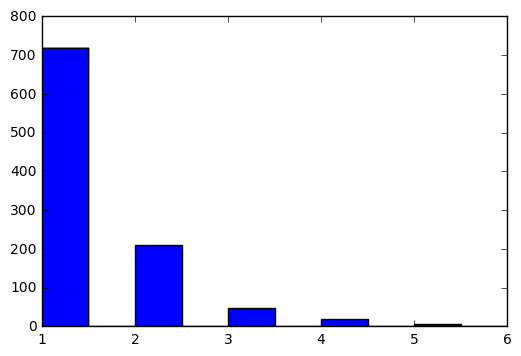

In [95]:
num_datapoints = np.int32(np.random.exponential(.8, size=(1000))) + 1
plt.hist(num_datapoints)

We have 5000 clients:

In [96]:
clients = [Client(lambda: sample_suggestions(np.int32(np.random.exponential(.8)) + 1)) for _ in range(5000)]

In [103]:
sc.cancelAllJobs()

In [104]:
server = Server(clients)
server.fit(optimizer=GradientDescent(30.),
          num_iterations=48,
           num_clients_per_iteration=400,
          callbacks=[ModelCheckpoint(rank_accuracy, 10000)])

[1/48] training loss across clients 11.55919
[ModelCheckpoint] New best model with 0.66620 validation accuracy
[2/48] training loss across clients 14.76246
[ModelCheckpoint] New best model with 0.94450 validation accuracy
[3/48] training loss across clients 5.16298
validation: 0.916 accuracy
[4/48] training loss across clients 1.49055
[ModelCheckpoint] New best model with 0.96140 validation accuracy
[5/48] training loss across clients 0.42169
[ModelCheckpoint] New best model with 0.97910 validation accuracy
[6/48] training loss across clients 0.07640
[ModelCheckpoint] New best model with 0.99040 validation accuracy
[7/48] training loss across clients 0.07736
[ModelCheckpoint] New best model with 0.99600 validation accuracy
[8/48] training loss across clients 0.05581
validation: 0.995 accuracy
[9/48] training loss across clients 0.04161
validation: 0.995 accuracy
[10/48] training loss across clients 0.00094
validation: 0.994 accuracy
[11/48] training loss across clients 0.01516
validati

=> The model quality improved from 70% to 97% validation accuracy.

Simplifications made:

- All users sample from the same distribution
- `ModelCheckpoint` cannot be based on validation data in the actual implementation
- Users should run more than one SGD iteration locally

---

# Debugging

This part is just for checking wrong predictions:

In [45]:
preds = [t.argmax() for t in model.predict(X)]

In [46]:
labels = [yi.argmax() for yi in y]

In [47]:
zip(range(len(labels)), labels, preds)[:20]

[(0, 4, 4),
 (1, 2, 2),
 (2, 0, 0),
 (3, 3, 3),
 (4, 6, 0),
 (5, 8, 8),
 (6, 0, 0),
 (7, 5, 5),
 (8, 7, 7),
 (9, 4, 4),
 (10, 6, 6),
 (11, 0, 0),
 (12, 3, 3),
 (13, 4, 4),
 (14, 0, 0),
 (15, 3, 3),
 (16, 10, 10),
 (17, 1, 1),
 (18, 5, 5),
 (19, 6, 6)]

In [48]:
y[5]

array([ 120.,   12.,  100.,   12.,   12.,   14.,  100.,   12.,  200.,
         60.,  120.,   20.,  140.])

In [49]:
model.predict(X)[5]

array([  49.92694721, -137.10912544,   -4.73356417, -137.10912544,
       -137.10912544,  -74.82064343,   -4.73356417, -137.10912544,
        215.42174025,  -52.96476446,   49.92694721,  -73.3331873 ,
        127.3231452 ])

In [50]:
X[9][2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.])

---

# Notes

## To make fitting easier

- Fair initialization
- Normalize data (0-center)
- Remove features with a value of 0

## Still missing

- Implement frequency part (switch from one-hot encoding to up to sum of 10 and add multiplicative factor)
- Federated Learning

---

# Backup

### Random noise

In [51]:
y = [yi + np.random.normal(0, 2, size=(n)) for yi, n in zip(y, num_options)]

ValueError: operands could not be broadcast together with shapes (9,) (15,) 

### Other optimizers

In [ ]:
class DecayedGradientDescent:
    def __init__(self, learning_rate, decay):
        self.learning_rate = learning_rate
        self.decay = decay
        self.epoch = 0
        
    def __call__(self, gradient):
        result = self.learning_rate * gradient
        
        self.learning_rate = self.learning_rate * 1 / (1 + self.decay * self.epoch)
        self.epoch += 1
            
        return result

In [ ]:
model = SVMRanking(delta=1)
model.fit(X, y, optimizer=DecayedGradientDescent(0.5, .0000001), num_iterations=3000)

In [65]:
class Adam:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.alpha = 0.01
        self.eps = 1e-8
        
        self.t = 0
        
        self.m = None
        self.v = None
        self.theta = None
    
    def __call__(self, gradient):
        if self.t == 0:
            self.m = np.zeros(gradient.shape)
            self.v = np.zeros(gradient.shape)
            self.theta = np.zeros(gradient.shape)
        
        self.t += 1
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradient**2
        
        m_corrected = self.m / (1 - self.beta1**self.t)
        v_corrected = self.v / (1 - self.beta2**self.t)

        self.theta += self.alpha * m_corrected / (np.sqrt(v_corrected) + self.eps)
        
        return self.learning_rate * self.theta

In [ ]:
opt = Adam(learning_rate=0.1)
model = SVMRanking(delta=0)
model.fit(X, y, optimizer=opt, num_iterations=300)

In [ ]:
opt.theta